# Oscillating Circuit Voltage Behaviour
Author: Jan Hoegen \
Date: 2023-12-14

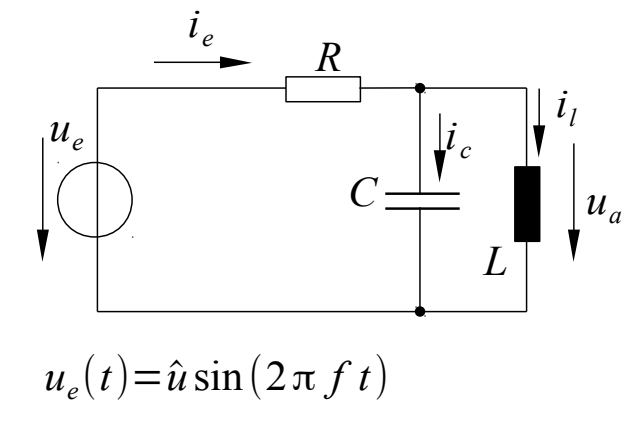

Passwort Lösungenordner: rooyen

In [25]:
from math import pi, sqrt
import numpy as np 
import matplotlib.pyplot as plt
from scipy import signal as sig
from scipy import integrate as sci
from OMPython import ModelicaSystem
import pandas as pd

In [26]:
VOLTAGE_MAX =   2       # V
FREQUENCY   =   1       # Hz
RESISTOR    =   20      # Ohm
COIL        =   9e-3    # H
CAPACITOR   =   1000e-6 # F

TOTALTIME   =   2       # s
TIMESTEP    =   1e-3    # s

plt.rcParams['axes.grid'] = True

## Solving ODE with SCIPY-Function
Das Entfernen von `method='LSODA'` hat keinen Effekt. Die Scipy-Funktion wählt eigenständig eine geeignete Methode aus.

Die Energie wird zwischen Kondensator und Spule periodisch ausgetauscht. Ihr komplexer Widerstand kompensiert sich. Bei ausreichender Kompensation dominiert der ohmsche Verbraucher.

In [27]:
time = np.arange(0, TOTALTIME, TIMESTEP)

SYSTEM_ARRAY=np.array([[-1/(RESISTOR*CAPACITOR),    -1/CAPACITOR], 
                                        [1/COIL,    0]])
INPUT_ARRAY=np.array([[1/(RESISTOR*CAPACITOR)],
                                           [0]])
OUTPUT_ARRAY=np.array([[           1,   0],
                        [          0,   1],
                        [-1/RESISTOR,   0]])
TRANSIT_ARRAY=np.array([         [0],
                                 [0],
                        [1/RESISTOR]])

INITIAL_STATE = np.array([0,0])     # = [outputvoltage, outputcurrent]

def input_voltage(time):
    return VOLTAGE_MAX * np.sin(2 * pi * FREQUENCY * time)

def state_derivative(time, state):
    state=np.reshape(state, (2,1))
    state_derivative = SYSTEM_ARRAY.dot(state) + INPUT_ARRAY * input_voltage(time)
    return np.reshape(state_derivative, (1,2)) 

def result_array(state, time):
    return OUTPUT_ARRAY.dot(state) + TRANSIT_ARRAY * input_voltage(time)

ode_solution = sci.solve_ivp(state_derivative, [0, TOTALTIME], INITIAL_STATE, t_eval=time).y

results = result_array(ode_solution, time)

array([<Axes: xlabel='time in s'>, <Axes: xlabel='time in s'>,
       <Axes: xlabel='time in s'>, <Axes: xlabel='time in s'>],
      dtype=object)

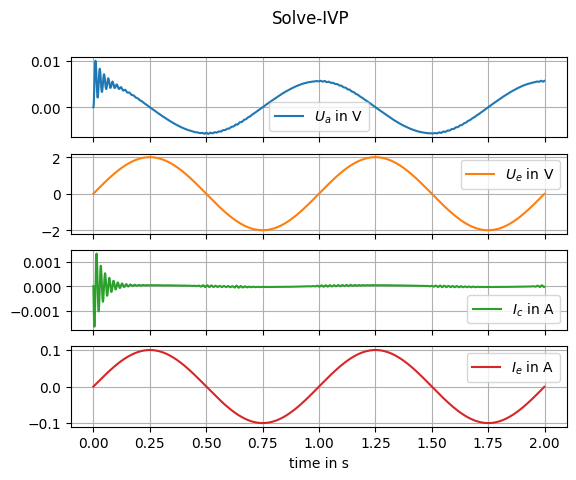

In [28]:
task1 = pd.DataFrame({
    "time in s":    time,
    "$U_a$ in V":   results[0], 
    "$U_e$ in V":   input_voltage(time), 
    "$I_c$ in A":   results[1] - results[2],
    "$I_e$ in A":   results[2],
})
task1 = task1.set_index("time in s")

task1.plot(subplots=True, title="Solve-IVP")

## Solving ODE with Open-Modelica and Constants
Unresolved Error in $I_a$. It behaves the same as $I_e$, but an amplitude close to $0 A$ for $t>0.25s$ is expected. The model solution is probably not retuned correctly.  

In [29]:
modelname = "resonant_circuit"
model = ModelicaSystem(modelname+".mo", modelname)
model.setSimulationOptions('stopTime=2.0')

model.simulate()

Notification: Automatically loaded package Complex 4.0.0 due to uses annotation from Modelica.
Notification: Automatically loaded package ModelicaServices 4.0.0 due to uses annotation from Modelica.
Notification: Automatically loaded package Modelica 4.0.0 due to usage.



Exception ignored in: <function ModelicaSystem.__del__ at 0x0000016D7FC51080>
Traceback (most recent call last):
  File "c:\Users\janho\scoop\apps\python\current\Lib\site-packages\OMPython\__init__.py", line 862, in __del__
    OMCSessionBase.__del__(self)
  File "c:\Users\janho\scoop\apps\python\current\Lib\site-packages\OMPython\__init__.py", line 172, in __del__
    self._omc_log_file.close()
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'ModelicaSystem' object has no attribute '_omc_log_file'


array([<Axes: xlabel='time in s'>, <Axes: xlabel='time in s'>,
       <Axes: xlabel='time in s'>, <Axes: xlabel='time in s'>],
      dtype=object)

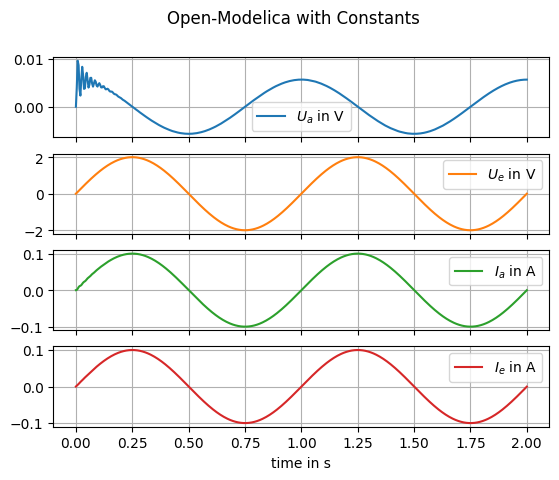

In [30]:
task2 = pd.DataFrame({
    "time in s":    model.getSolutions('time').ravel(),
    "$U_a$ in V":   model.getSolutions("u_a").ravel(),
    "$U_e$ in V":   model.getSolutions("u_e").ravel(),
    "$I_a$ in A":   model.getSolutions("i_L").ravel(),
    "$I_e$ in A":   model.getSolutions("i_e").ravel(),
})
task2 = task2.set_index("time in s")

task2.plot(subplots=True, title="Open-Modelica with Constants")

## Solving ODE with Open-Modelica and Variable Parameters

In [31]:
modelname = "blockdiagram"
model = ModelicaSystem(modelname+".mo", modelname)
model.setSimulationOptions('stopTime=2.0')
model.setParameters(f'resistor1.R={RESISTOR}')
model.setParameters(f'inductor1.L={COIL}')
model.setParameters(f'capacitor1.C={CAPACITOR}')

model.simulate()

Notification: Automatically loaded package Complex 4.0.0 due to uses annotation from Modelica.
Notification: Automatically loaded package ModelicaServices 4.0.0 due to uses annotation from Modelica.
Notification: Automatically loaded package Modelica 4.0.0 due to usage.
[C:/Users/janho/AppData/Roaming/.openmodelica/libraries/Modelica 4.0.0+maint.om/Electrical/Analog/Sources/SineVoltage.mo:5:3-5:61:writable] Warning: Parameter sineVoltage1.f has no value, and is fixed during initialization (fixed=true), using available start value (start=1.0) as default value.



array([<Axes: xlabel='time in s'>, <Axes: xlabel='time in s'>,
       <Axes: xlabel='time in s'>, <Axes: xlabel='time in s'>],
      dtype=object)

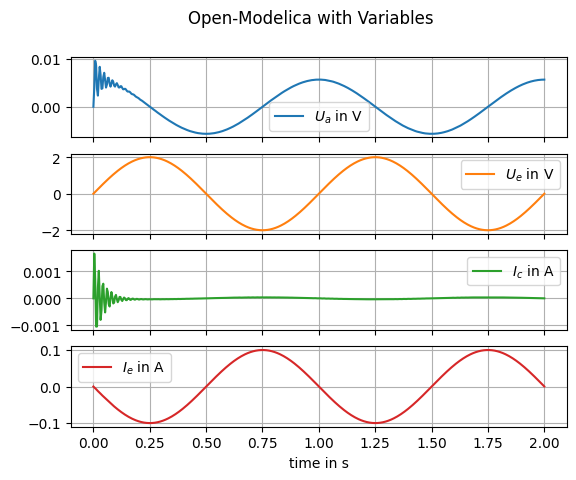

In [32]:
task3 = pd.DataFrame({
    "time in s":    model.getSolutions('time').ravel(),
    "$U_a$ in V":   model.getSolutions("inductor1.v").ravel(),
    "$U_e$ in V":   model.getSolutions("sineVoltage1.v").ravel(),
    "$I_c$ in A":   model.getSolutions("capacitor1.i").ravel(),
    "$I_e$ in A":   model.getSolutions("sineVoltage1.i").ravel()
})
task3 = task3.set_index("time in s")

task3.plot(subplots=True, title="Open-Modelica with Variables")

## Frequencies of the Circuit

Die Eigenfrequenz ist durch $ f_0 = \frac{1}{2 \pi \tau} $ gekennzeichnet.

In [33]:
model.setSimulationOptions('stopTime=0.1')
model.simulate()

array([<Axes: xlabel='time in s'>, <Axes: xlabel='time in s'>],
      dtype=object)

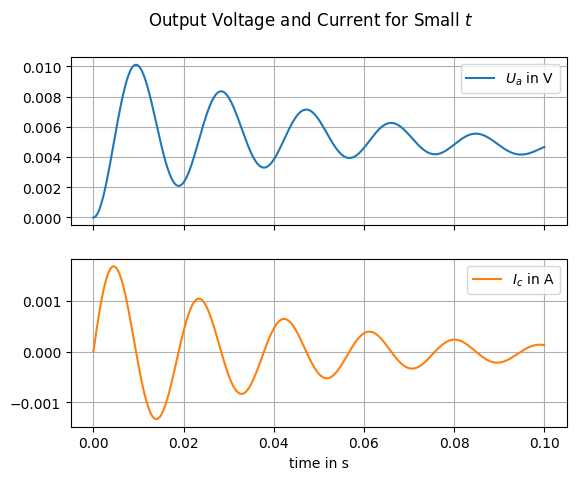

In [34]:
task4 = pd.DataFrame({
    "time in s":    model.getSolutions('time').ravel(),
    "$U_a$ in V":   model.getSolutions("inductor1.v").ravel(),
    "$U_e$ in V":   model.getSolutions("sineVoltage1.v").ravel(),
    "$I_c$ in A":   model.getSolutions("capacitor1.i").ravel(),
    "$I_e$ in A":   model.getSolutions("sineVoltage1.i").ravel()
})
task4 = task4.set_index("time in s")

task4.plot(subplots=True, title="Output Voltage and Current for Small $t$", y=["$U_a$ in V", "$I_c$ in A"])

## Bode Diagram and Pole Points Diagramm

Mit anwenden des Spannungsteilers ergibt sich $U_a(t) = U_e(t) \cdot \frac{X_L || X_C}{R + X_L || X_C}$.

Die Übertragungsfunktion lautet demnach
$$G(s) = \frac{U_a(s)}{U_e(s)} = \frac{ \frac{sL}{1+s^2LC} }{ R + \frac{sl}{1+s^2LC} } = \frac{ s \frac{L}{R} }{ s^2 LC + s\frac{L}{R} + 1} $$

und die Eigenwerte der Systemmatrix ergeben sich zu
$$
    \begin{pmatrix}
        -\frac{1}{RC}-\lambda   &   -\frac{1}{C}\\
        \frac{1}{L}             &   -\lambda
    \end{pmatrix}

    = \frac{\lambda}{RC} + \lambda^2 + \frac{1}{LC}.
$$

Die Eigenfrequenz wird mit $ f_0 = \frac{1}{2 \pi \tau} = \frac{1}{ 2 \pi \frac{RL}{R+L} } $ berechnet.

In [35]:
resonant_frequency = 1 / (2 * pi * RESISTOR * COIL / ( RESISTOR + COIL ) )

NUMERATOR = [COIL / RESISTOR, 0]
DENOMINATOR = [COIL * CAPACITOR, COIL / RESISTOR, 1]

system = sig.TransferFunction(NUMERATOR, DENOMINATOR)
angular_f, magnitude, phase = sig.bode(system)
zeros = system.zeros
poles = system.poles
print(f"Poles:\t\t\t{poles}\nZero Points:\t\t{zeros}\nResonant frequency:\t{resonant_frequency} Hz")


Poles:			[-25.+332.39451125j -25.-332.39451125j]
Zero Points:		[0.]
Resonant frequency:	17.691840312920746 Hz


Exception ignored in: <function ModelicaSystem.__del__ at 0x0000016D7FC51080>
Traceback (most recent call last):
  File "c:\Users\janho\scoop\apps\python\current\Lib\site-packages\OMPython\__init__.py", line 862, in __del__
    OMCSessionBase.__del__(self)
  File "c:\Users\janho\scoop\apps\python\current\Lib\site-packages\OMPython\__init__.py", line 172, in __del__
    self._omc_log_file.close()
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'ModelicaSystem' object has no attribute '_omc_log_file'


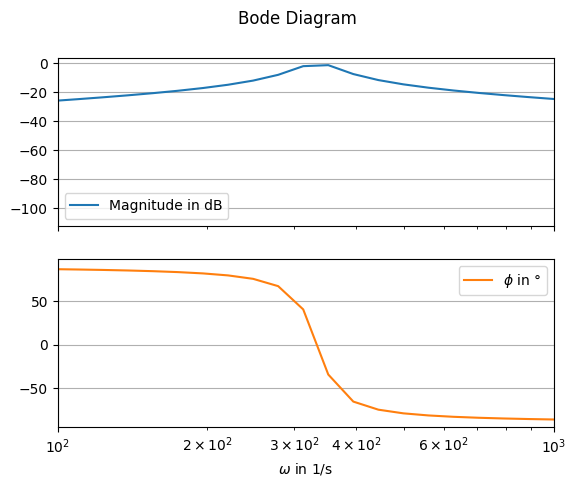

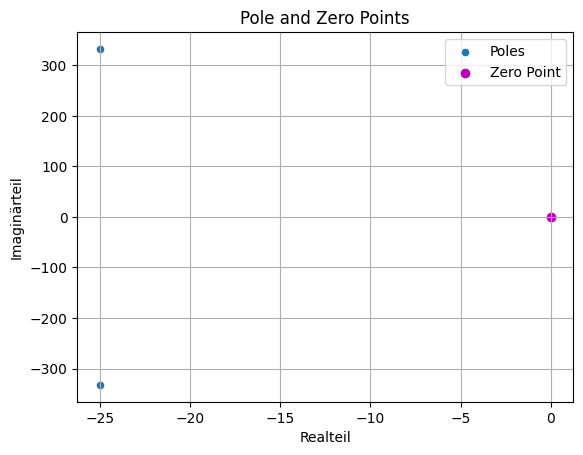

In [36]:
task5 = pd.DataFrame({
    r"$\omega$ in 1/s":  angular_f,
    "Magnitude in dB":  magnitude,
    r"$\phi$ in °":      phase,
})
task5 = task5.set_index(r"$\omega$ in 1/s")

task5.plot(subplots=True, title="Bode Diagram", logx=True, xlim=(100,1000))

task51 = pd.DataFrame({
    "Realteil":     poles.real,
    "Imaginärteil": poles.imag,
})
ax = task51.plot.scatter(x="Realteil",y="Imaginärteil", title="Pole and Zero Points", label="Poles")
ax = plt.scatter(x=0, y=zeros, label="Zero Point", color="m")
plt.legend()